In [1]:
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.maxResultSize", "2g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [6]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [24, 28, 29, 35, 36]},
            },
        },
        {
            $project: {
                tag: true,
                aq: true,
                gm2: true,
                nhits: {
                    $sum: {
                        $map: {
                            input: "$hits",
                            as: "h",
                            in: {$cond: {if: {$and: [{$gte: ["$$h.t", 7360]},  /* CHHII+ */
                                                     {$lt: ["$$h.t", 7440]},
                                                     {$gt: ["$$h.x", -10]},
                                                     {$lt: ["$$h.x", 10]},
                                                     {$gt: ["$$h.y", -10]},
                                                     {$lt: ["$$h.y", 10]},
                                                     {$lte: ["$$h.flag", 14]}]}, then: 1, else: 0}},
                        },                    
                    }
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("aq", LongType()),
            StructField("gm2", DoubleType()),
            StructField("nhits", LongType()),
        ])
    )
    .load()
)
df.printSchema()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- aq: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- nhits: long (nullable = true)

Done!


In [8]:
pdf = df.toPandas()
pdf.head()

,tag,aq,gm2,nhits
0,158648231,35,0.009929,0
1,158648232,35,0.008909,0
2,158648233,35,0.009239,0
3,158648234,35,0.009721,0
4,158648235,35,0.007615,0


In [9]:
pdf["aq"].unique()

array([35, 36, 28, 29])

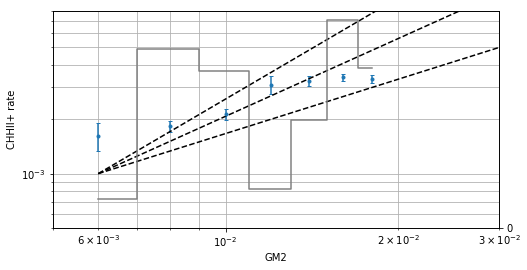

In [123]:
step = 0.002
edges = np.arange(0.005, 0.021, step)
shots, _ = np.histogram(pdf["gm2"], bins=edges)
hist, _ = np.histogram(pdf["gm2"], weights=pdf["nhits"], bins=edges)
where = 0 < hist

plt.figure(figsize=(8, 4))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    edges[:-1][where] + step / 2,
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
plt.xlim(5e-3, 3e-2)
plt.ylim(5e-4, 8e-3)
plt.plot([6e-3, 5*6e-3], [1e-3, 5*1e-3], "--k")
plt.plot([6e-3, 5*6e-3], [1e-3, 10*1e-3], "--k")
plt.plot([6e-3, 5*6e-3], [1e-3, 20*1e-3], "--k")
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

plt.twinx()
plt.step(edges[:-1] + step / 2, shots, "grey", where="mid")
# plt.step(edges[1:], shots, "grey")
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()

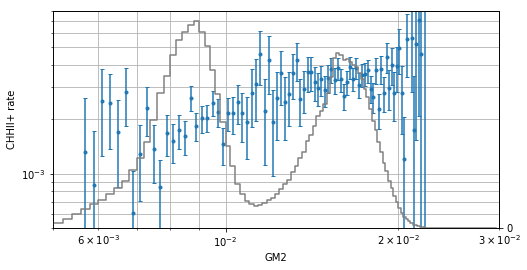

In [50]:
step = 0.0002
edges = np.arange(0, 0.03, step)
shots, _ = np.histogram(pdf["gm2"], bins=edges)
hist, _ = np.histogram(pdf["gm2"], weights=pdf["nhits"], bins=edges)
where = 0 < hist

plt.figure(figsize=(8, 4))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    edges[:-1][where] + step / 2,
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
plt.xlim(5e-3, 3e-2)
plt.ylim(5e-4, 8e-3)
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

plt.twinx()
plt.step(edges[1:], shots, "grey")
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()

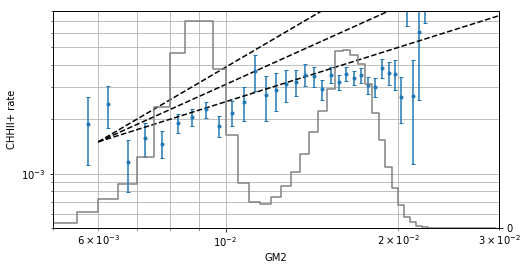

In [62]:
step = 0.0005
edges = np.arange(0, 0.03, step)
shots, _ = np.histogram(pdf["gm2"], bins=edges)
hist, _ = np.histogram(pdf["gm2"], weights=pdf["nhits"], bins=edges)
where = 0 < hist

plt.figure(figsize=(8, 4))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    edges[:-1][where] + step / 2,
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
plt.plot([6e-3, 5*6e-3], [1.5e-3, 5*1.5e-3], "--k")
plt.plot([6e-3, 5*6e-3], [1.5e-3, 10*1.5e-3], "--k")
plt.plot([6e-3, 5*6e-3], [1.5e-3, 20*1.5e-3], "--k")
plt.xlim(5e-3, 3e-2)
plt.ylim(5e-4, 8e-3)
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

plt.twinx()
plt.step(edges[1:], shots, "grey")
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()

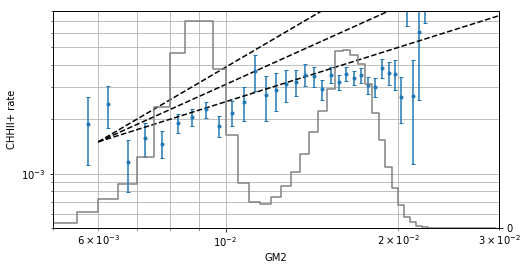

In [63]:
step = 0.0005
edges = np.arange(0, 0.03, step)
shots, _ = np.histogram(pdf["gm2"], bins=edges)
hist, _ = np.histogram(pdf["gm2"], weights=pdf["nhits"], bins=edges)
where = 0 < hist

plt.figure(figsize=(8, 4))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    edges[:-1][where] + step / 2,
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
plt.plot([6e-3, 5*6e-3], [1.5e-3, 5*1.5e-3], "--k")
plt.plot([6e-3, 5*6e-3], [1.5e-3, 10*1.5e-3], "--k")
plt.plot([6e-3, 5*6e-3], [1.5e-3, 20*1.5e-3], "--k")
plt.xlim(5e-3, 3e-2)
plt.ylim(5e-4, 8e-3)
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

plt.twinx()
plt.step(edges[1:], shots, "grey")
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()

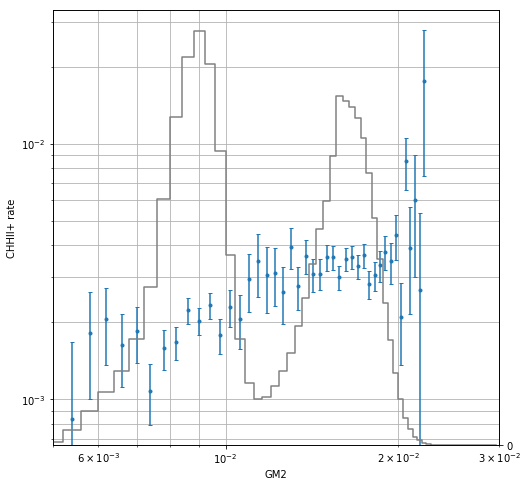

In [85]:
step = 0.0004
edges = np.arange(0, 0.03, step)
x = edges[:-1] + step / 2
shots, _ = np.histogram(pdf["gm2"], bins=edges)
hist, _ = np.histogram(pdf["gm2"], weights=pdf["nhits"], bins=edges)
where = 0 < hist
# fr, to = 0, np.inf
# fr, to = 0.01, 0.02
# roi = (fr <= x) & (x < to)

plt.figure(figsize=(8, 8))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    x[where],
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
# model = PowerLawModel()
# fitted = model.fit(
#     hist[where & roi] / shots[where & roi],
#     weights=shots[where & roi] ** 2 / hist[where & roi],
#     x=x[where & roi])
# plt.plot(x, fitted.eval(x=x))
# plt.axvspan(max(0.005, fr), min(to, 0.03), alpha=0.2)

# plt.plot([6e-3, 5*6e-3], [1.5e-3, 5*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 10*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 20*1.5e-3], "--k")
plt.xlim(5e-3, 3e-2)
# plt.ylim(5e-4, 8e-3)
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

plt.twinx()
plt.step(edges[1:], shots, "grey")
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()

fitted

In [67]:
from lmfit.models import LinearModel, PowerLawModel

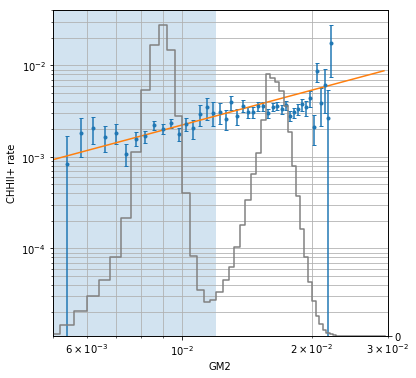

In [100]:
step = 0.0004
edges = np.arange(0, 0.03, step)
x = edges[:-1] + step / 2
shots, _ = np.histogram(pdf["gm2"], bins=edges)
hist, _ = np.histogram(pdf["gm2"], weights=pdf["nhits"], bins=edges)
where = 0 < hist
# fr, to = 0, np.inf
# fr, to = 0.012, 0.02
# fr, to = 0.008, 0.012
fr, to = 0.005, 0.012
roi = (fr <= x) & (x < to)

plt.figure(figsize=(6, 6))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    x[where],
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
model = PowerLawModel()
fitted = model.fit(
    hist[where & roi] / shots[where & roi],
    weights=shots[where & roi] ** 2 / hist[where & roi],
    x=x[where & roi])
plt.plot(x, fitted.eval(x=x))
plt.axvspan(max(0.005, fr), min(to, 0.03), alpha=0.2)

# plt.plot([6e-3, 5*6e-3], [1.5e-3, 5*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 10*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 20*1.5e-3], "--k")
plt.xlim(5e-3, 3e-2)
# plt.ylim(5e-4, 8e-3)
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

plt.twinx()
plt.step(edges[1:], shots, "grey")
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()

fitted

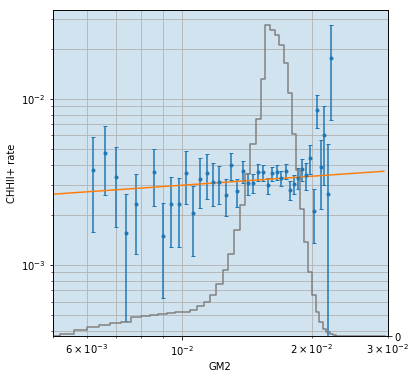

In [112]:
step = 0.0004
edges = np.arange(0, 0.03, step)
x = edges[:-1] + step / 2
which = pdf["aq"].isin([28, 29])
shots, _ = np.histogram(pdf[which]["gm2"], bins=edges)
hist, _ = np.histogram(pdf[which]["gm2"], weights=pdf[which]["nhits"], bins=edges)
where = 0 < hist
fr, to = 0, np.inf
# fr, to = 0.012, 0.02
# fr, to = 0.008, 0.012
# fr, to = 0.005, 0.012
roi = (fr <= x) & (x < to)

plt.figure(figsize=(6, 6))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    x[where],
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
model = PowerLawModel()
fitted = model.fit(
    hist[where & roi] / shots[where & roi],
    weights=shots[where & roi] ** 2 / hist[where & roi],
    x=x[where & roi])
plt.plot(x, fitted.eval(x=x))
plt.axvspan(max(0.005, fr), min(to, 0.03), alpha=0.2)

# plt.plot([6e-3, 5*6e-3], [1.5e-3, 5*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 10*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 20*1.5e-3], "--k")
plt.xlim(5e-3, 3e-2)
# plt.ylim(5e-4, 8e-3)
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

plt.twinx()
plt.step(edges[1:], shots, "grey")
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()

fitted

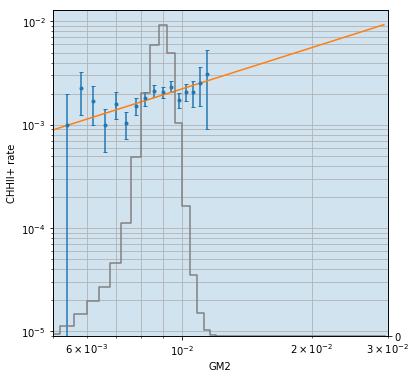

In [111]:
step = 0.0004
edges = np.arange(0, 0.03, step)
x = edges[:-1] + step / 2
which = pdf["aq"].isin([35, 36])
shots, _ = np.histogram(pdf[which]["gm2"], bins=edges)
hist, _ = np.histogram(pdf[which]["gm2"], weights=pdf[which]["nhits"], bins=edges)
where = 0 < hist
fr, to = 0, np.inf
# fr, to = 0.012, 0.02
# fr, to = 0.008, 0.012
# fr, to = 0.005, 0.012
roi = (fr <= x) & (x < to)

plt.figure(figsize=(6, 6))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    x[where],
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
model = PowerLawModel()
fitted = model.fit(
    hist[where & roi] / shots[where & roi],
    weights=shots[where & roi] ** 2 / hist[where & roi],
    x=x[where & roi])
plt.plot(x, fitted.eval(x=x))
plt.axvspan(max(0.005, fr), min(to, 0.03), alpha=0.2)

# plt.plot([6e-3, 5*6e-3], [1.5e-3, 5*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 10*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 20*1.5e-3], "--k")
plt.xlim(5e-3, 3e-2)
# plt.ylim(5e-4, 8e-3)
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

plt.twinx()
plt.step(edges[1:], shots, "grey")
plt.ylim(0, None)
plt.yticks([0], [0])
plt.show()

fitted

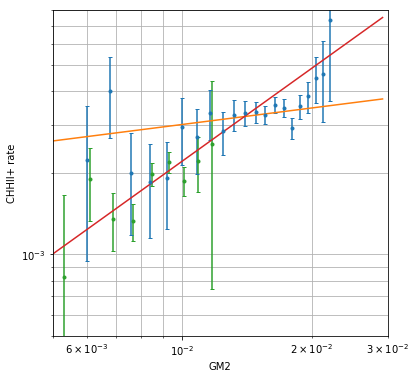

In [120]:
step = 0.0008
edges = np.arange(0, 0.03, step)
x = edges[:-1] + step / 2

which = pdf["aq"].isin([28, 29])
shots, _ = np.histogram(pdf[which]["gm2"], bins=edges)
hist, _ = np.histogram(pdf[which]["gm2"], weights=pdf[which]["nhits"], bins=edges)
where = 0 < hist
fr, to = 0, np.inf
# fr, to = 0.012, 0.02
# fr, to = 0.008, 0.012
# fr, to = 0.005, 0.012
roi = (fr <= x) & (x < to)

plt.figure(figsize=(6, 6))
plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    x[where],
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
model = PowerLawModel()
fitted = model.fit(
    hist[where & roi] / shots[where & roi],
    weights=shots[where & roi] ** 2 / hist[where & roi],
    x=x[where & roi])
plt.plot(x, fitted.eval(x=x))
# plt.axvspan(max(0.005, fr), min(to, 0.03), alpha=0.2)

which = pdf["aq"].isin([35, 36])
shots, _ = np.histogram(pdf[which]["gm2"], bins=edges)
hist, _ = np.histogram(pdf[which]["gm2"], weights=pdf[which]["nhits"], bins=edges)
where = 0 < hist
fr, to = 0, np.inf
# fr, to = 0.012, 0.02
# fr, to = 0.008, 0.012
# fr, to = 0.005, 0.012
roi = (fr <= x) & (x < to)

plt.xlabel("GM2")
plt.ylabel("CHHII+ rate")
plt.errorbar(
    x[where] + 0.0001,
    hist[where] / shots[where],
    hist[where] ** 0.5 / shots[where],
    fmt=".",
    capsize=2,
)
model = PowerLawModel()
fitted = model.fit(
    hist[where & roi] / shots[where & roi],
    weights=shots[where & roi] ** 2 / hist[where & roi],
    x=x[where & roi])
plt.plot(x, fitted.eval(x=x))
# plt.axvspan(max(0.005, fr), min(to, 0.03), alpha=0.2)

# plt.plot([6e-3, 5*6e-3], [1.5e-3, 5*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 10*1.5e-3], "--k")
# plt.plot([6e-3, 5*6e-3], [1.5e-3, 20*1.5e-3], "--k")
plt.xlim(5e-3, 3e-2)
plt.ylim(5e-4, 8e-3)
plt.xscale("log")
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")

# plt.twinx()
# plt.step(edges[1:], shots, "grey")
# plt.ylim(0, None)
# plt.yticks([0], [0])
plt.show()